<a href="https://colab.research.google.com/github/LuluW8071/Text-Sentiment-Analysis/blob/main/Text-Sentiment-Analysis-using-BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text-Sentiment-Analysis-using-BERT

In [ ]:
!pip install transformers[torch] datasets

## 1. Download and Load the dataset

The dataset that the following script will download is a combination of the Yelp Polarity Dataset and the IMDb Movie Dataset. The Yelp Polarity Dataset has been preprocessed by selecting specific columns to create a dataset suitable for sentiment analysis. This preprocessed dataset has been merged with the IMDb Movie Dataset.

In [ ]:
import os
import gdown
import zipfile

file_url = 'https://drive.google.com/uc?id=1Jp3D5gdxGrwa5dHbr4p-pECrD8wi7vik'
file_name = 'sentiment_dataset.zip'

# Download the file from Google Drive
gdown.download(file_url, file_name, quiet=False)
extract_dir = './dataset'

# Extract the zip file
with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Remove the zip file after extraction
os.remove(file_name)
print("Files extracted successfully to:", extract_dir)

Downloading...
From (original): https://drive.google.com/uc?id=1Jp3D5gdxGrwa5dHbr4p-pECrD8wi7vik
From (redirected): https://drive.google.com/uc?id=1Jp3D5gdxGrwa5dHbr4p-pECrD8wi7vik&confirm=t&uuid=9e9d5b81-a1e6-40dd-8234-de5e75615211
To: /content/sentiment_dataset.zip
100%|██████████| 182M/182M [00:05<00:00, 31.4MB/s]


Files extracted successfully to: ./dataset


>__Note:__</br>
**BERT** (Bidirectional Encoder Representations from Transformers) can indeed be trained on a relatively small dataset to yield improved results for certain tasks, especially when fine-tuning a pre-trained model, due to its powerful architecture. It is already pre-trained on larger datasets, possesses powerful contextual understanding, and benefits from effective regularization techniques such as dropout and attention mechanisms, which help prevent overfitting.

>So, we can just take just `20000` datasets and train the **BERT** Model on it for our purpose.

In [ ]:
import random
import pandas as pd
import numpy as np

# Reduce to 10000 samples if you want your model to train faster (while loss may increase)
samples = 20000

# Read dataset and take random 20000 samples
df = pd.read_csv("dataset/sentiment_combined.csv")
df = df.sample(n=samples, random_state=random.randint(0, 100))

# Reset the index
df.reset_index(drop=True, inplace=True)
df.head(), df.shape

(                                              review sentiment
 0  The minicupcakes are cute and taste sweet but ...  negative
 1  We had went to the old Satified Frog frequentl...  negative
 2  Very unprofessional front of the house staff. ...  negative
 3  We stopped by to check out the happy hour spec...  positive
 4  The pear dessert crepe was super delicious!  T...  positive,
 (20000, 2))

In [ ]:
df['review'][0]

"The minicupcakes are cute and taste sweet but the vanilla has a strange aftertaste from the frosting. The black and white is good though. Meanwhile their ice creams (cap'n ' crunch, salted caramel, cherry vanilla) are all atrocious. I've literally never tasted ice cream this bad. The salted caramel just tastes like salt, the cap n' crunch is crappy soggy peanut butter mush and the cherry vanilla just tastes like a bad imitation of Ben and Jerry's. The worst by far is not using the berry cap n crunch. Holstein's and Momofuku is much better."

In [ ]:
df['sentiment'].value_counts()

sentiment
positive    10165
negative     9835
Name: count, dtype: int64

## 2. Text Pre-Processing

- Cleaning up the text data by removing punctuation, extra spaces, and numbers.
- Transform sentences into individual words, remove common words (known as "stop words")

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from collections import Counter

# Precompile regular expressions for faster pre processing
non_word_chars_pattern = re.compile(r"[^\w\s]")
whitespace_pattern = re.compile(r"\s+")
digits_pattern = re.compile(r"\d")
username_pattern = re.compile(r"@([^\s]+)")
hashtags_pattern = re.compile(r"#\d+")
br_pattern = re.compile(r'<br\s*/?>\s*<br\s*/?>')

def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = non_word_chars_pattern.sub('', s)
    # Replace all runs of whitespaces with single space
    s = whitespace_pattern.sub(' ', s)
    # Replace digits with no space
    s = digits_pattern.sub('', s)
    # Replace usernames with no space
    s = username_pattern.sub('', s)
    # Replace hashtags with no space
    s = hashtags_pattern.sub('', s)
    # Replace <br /> pattern with empty string
    s = br_pattern.sub('', s)
    # Replace specific characters
    s = s.replace("https", "")
    s = s.replace("http", "")
    s = s.replace("rt", "")
    s = s.replace("-", "")
    # Replace br with empty string
    s = s.replace("br", "")
    # Replace newline character with empty string
    s = s.replace("\n", "")
    return s

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from tqdm.notebook import tqdm_notebook

preprocessed_reviews = []

# Apply preprocessing
for review in tqdm_notebook(df['review'], desc='Preprocessing'):
    preprocessed_review = preprocess_string(review)
    preprocessed_reviews.append(preprocessed_review)

# Assign the preprocessed reviews back to  'review' column
df['review'] = preprocessed_reviews

Preprocessing:   0%|          | 0/20000 [00:00<?, ?it/s]

In [ ]:
df['review'][0], df['sentiment'][0]

('The minicupcakes are cute and taste sweet but the vanilla has a strange afteaste from the frosting The black and white is good though Meanwhile their ice creams capn crunch salted caramel cherry vanilla are all atrocious Ive literally never tasted ice cream this bad The salted caramel just tastes like salt the cap n crunch is crappy soggy peanut butter mush and the cherry vanilla just tastes like a bad imitation of Ben and Jerrys The worst by far is not using the berry cap n crunch Holsteins and Momofuku is much better',
 'negative')

## 3. Mapping `sentiment` column to numeric values

In [ ]:
# Map 'positive' to 1 & 'negative' to 0
df['sentiment'] = df['sentiment'].replace({'positive': 1, 'negative': 0})
df.head()

,review,sentiment
0,The minicupcakes are cute and taste sweet but ...,0
1,We had went to the old Satified Frog frequentl...,0
2,Very unprofessional front of the house staff T...,0
3,We stopped by to check out the happy hour spec...,1
4,The pear desse crepe was super delicious The p...,1


## 4. Spliiting datasets into train and test

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['review'],
                                                    df['sentiment'],
                                                    test_size=0.2)

len(X_train), len(X_test)

(16000, 4000)

In [ ]:
X_train, X_test, y_train, y_test = list(X_train), list(X_test), list(y_train), list(y_test)
X_train[:2], y_train[:2]

(['Dont ask me why I love this movie so muchMaybe it came at a time in my life I desperately wanted to fit in maybe it is the amazing monster effects maybe because I enjoyed the novel Cabal but Its probably because I LOVE Clive Barker I think its fair to warn you the movie and the novel have no true resolve and like me youll probably have a WTF moment at the end At least two sequels were planned but never came about due to the fact the movie flopped for a few reasons The studio made drastic cuts to the film cutting a good  or so minutes out of it and they did a HORRIBLE job promoting it The adves made it look like just another cheap slasher showing mainly the Button faceMask Decker character This is a movie about the monsters About fantasy About a place called Midian Its a story where the monsters are the good guys There is truly nothing else out there like it Its not a movie for everybody I suppose but it stands as one of Clives many great works Sit back and be prepared to be taken to

## 5. Preparing data using custom dataloader

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments

# Setting device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
class data(Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels

  def __getitem__(self, index):
    item = {key: torch.tensor(val[index]) for key, val in self.encodings.items()}
    item['labels'] = torch.tensor(self.labels[index])
    return item

  def __len__(self):
    return len(self.labels)

## 6. Load PreTrained BERT Model

**BERT** (Bidirectional Encoder Representations from Transformers) is a pre-trained language representation model developed by researchers at Google.

<img src = "https://i0.wp.com/neptune.ai/wp-content/uploads/2022/10/Attention_diagram_transformer.png?ssl=1">

- BERT architecture consists of `multiple encoder transformer blocks` stacked together.
- Each transformer block includes` multi-head self-attention` and `feed-forward neural networks`.
- `Multi-head self-attention` allows BERT to weigh word importance based on context, capturing long-range dependencies effectively.
- The output from `attention mechanisms` undergoes non-linear transformations via `feed-forward neural networks`.
- `Layer normalization` and `residual connections` stabilize training and facilitate gradient flow within each transformer block.
- `Positional encodings` preserve word order in sequences, aiding BERT in understanding the sequential nature of data.

>BERT is pre-trained on a large text corpus using tasks like masked language modeling and next sentence prediction. Fine-tuning on specific tasks involves adjusting the final layers of the pre-trained BERT model.

### [Explanation Video on BERT](https://www.youtube.com/watch?v=6ahxPTLZxU8)

In [ ]:
from huggingface_hub import notebook_login

# Paste hugging face token with write permission enabled and log in
notebook_login()

In [ ]:
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## 7. Tokenize and Create Encoded Dataset

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer)

# Tokenize with truncation and padding and create dataset from tokenized data
train_encoding = tokenizer(X_train, truncation=True, padding=True)
test_encoding = tokenizer(X_test, truncation=True, padding=True)

train_dataset = data(train_encoding, y_train)
test_dataset = data(test_encoding, y_test)

## 8. Fine-Tuning Distil BERT

Fine-tuning BERT, a pre-trained language model, allows us to adapt it to specific NLP tasks such as text classification, named entity recognition, sentiment analysis, and question answering.


<img src = "https://raw.githubusercontent.com/LuluW8071/Text-Sentiment-Analysis/dfa065d8169ae9d26460114e612118f5628d7dd3//assets/BERT-Fine-tuning-pipeline.png">

In [ ]:
batch_size = 32

training_args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-sentiment",
    num_train_epochs=4,                              # No of epochs to train
    per_device_train_batch_size=batch_size,          # Batch size for training per device
    per_device_eval_batch_size=batch_size,           # Batch size for evaluation per device
    learning_rate=2e-5,                              # Learning rate for optimizer
    warmup_steps=400,                                # No of warmup steps for the learning rate scheduler
    weight_decay=0.01,                               # Weight decay coefficient for regularization
    logging_dir='./logs',                            # Directory for logging training information
    load_best_model_at_end=True,                     # Whether to load the best model from checkpoints at the end of training
    logging_steps=400,                               # Log training metrics every `logging_steps` steps
    save_steps=400,                                  # Save model checkpoints every `save_steps` steps
    save_total_limit=2,                              # Save no of checkpoints
    eval_strategy = "steps",                         # When to run evaluation during training: steps, epochs or none
    fp16=True,                                       # Floating point 16 precision
    push_to_hub=True,                                # Save checkpoint in Hugging Face Hub
    report_to="tensorboard",                         # Enable TensorBoard integration
)


## 9. Train the Fine-Tuned BERT Model

In [ ]:
from datasets import load_metric

accuracy_metric = load_metric("accuracy")

# Compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    return accuracy

In [ ]:
# Label mapping
label_mapping = {0: 'negative', 1: 'positive'}

model = DistilBertForSequenceClassification.from_pretrained(model_name,
                                                            num_labels=2)

# Override the model configuration for custom labels
model.config.id2label = label_mapping
model.config.label2id = {v: k for k, v in label_mapping.items()}


trainer = Trainer(
    model=model,                      # The instantiated Transformers model to be trained
    args=training_args,               # Training arguments, defined above
    train_dataset=train_dataset,      # Training dataset
    eval_dataset=test_dataset,        # Evaluation dataset
    tokenizer=tokenizer,              # Tokenizer
    data_collator=data_collator,      # Data collator
    compute_metrics=compute_metrics,  # Function to compute metrics
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from accelerate import Accelerator

# Initialize Accelerator and Trainer
Accelerator()
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
400,0.389300,0.181316,0.932500
800,0.161900,0.166204,0.941250
1200,0.114600,0.200135,0.943000


Step,Training Loss,Validation Loss,Accuracy
400,0.389300,0.181316,0.932500
800,0.161900,0.166204,0.941250
1200,0.114600,0.200135,0.943000
1600,0.076300,0.211609,0.944000
2000,0.041600,0.225439,0.944500


TrainOutput(global_step=2000, training_loss=0.15671546173095702, metrics={'train_runtime': 1257.5696, 'train_samples_per_second': 50.892, 'train_steps_per_second': 1.59, 'total_flos': 8477913513984000.0, 'train_loss': 0.15671546173095702, 'epoch': 4.0})

## 10. Sentiment Prediction using custom text


In [ ]:
# Tokenize text, get output from model and predict
def predict_sentiment(model, tokenizer, text, device):
    tokenized = tokenizer(text, truncation=True, padding=True, return_tensors='pt').to(device)
    outputs = model(**tokenized)

    probs = F.softmax(outputs.logits, dim=-1)
    preds = torch.argmax(outputs.logits, dim=-1).item()
    probs_max = probs.max().detach().cpu().numpy()

    prediction = "Positive" if preds == 1 else "Negative"
    print(f'{text}\nSentiment: {prediction}\tProbability: {probs_max*100:.2f}%\n', end="-"*50 + "\n")
    # return prediction, probs_max

In [ ]:
texts = [
    "The traffic was horrendous this morning; I was stuck in it for over an hour.",
    "I was extremely disappointed with the quality of the product; it didn't meet my expectations at all.",
    "The customer service at the restaurant was very good; the staff went above and beyond to make us feel welcome.",
    "My recent stay at Paradise Resort was absolutely fantastic! From the moment I arrived, I was greeted with warm smiles and excellent service. The room was spacious, beautifully decorated, and spotlessly clean. I loved the breathtaking view from my balcony overlooking the pool and tropical gardens. The dining options were exceptional, and the resort's facilities were top-notch, offering everything from a fitness center to guided nature walks. Overall, Paradise Resort exceeded all my expectations, and I can't wait to return for another memorable stay!",
    "The movie started off promising, but it quickly went downhill. The plot was confusing, the acting was mediocre, and the ending was unsatisfying.",
    "I had a terrible experience at the restaurant last night. The food was cold, the service was slow, and the staff was rude.",
    "Despite the initial skepticism, I was pleasantly surprised by the performance of the new smartphone. Its sleek design, impressive camera quality, and fast processing speed exceeded my expectations.",
    "The concert was absolutely amazing! The energy of the performers, the enthusiasm of the crowd, and the quality of the music made it an unforgettable experience.",
    "I had high hopes for the book, but it turned out to be a disappointment. The characters were one-dimensional, the plot was predictable, and the writing style was uninspired.",
    "The presentation was well-prepared and delivered with confidence. The speaker engaged the audience effectively and provided valuable insights on the topic.",
    "The service at the hotel was impeccable. The staff was attentive, courteous, and always willing to assist with any request.",
    "The weather during our vacation was dreadful; it rained every day, and we were stuck indoors for most of the trip.",
    "The hiking trail offered breathtaking views of the mountains and lush forests. It was a challenging but rewarding experience.",
    "The customer support team was unhelpful and incompetent. They were unable to resolve my issue and seemed indifferent to my concerns.",
    "The play was a delightful blend of humor, drama, and suspense. The talented cast delivered stellar performances, and the storyline kept me engaged from start to finish.",
    "The new restaurant in town has quickly become my favorite dining spot. The food is delicious, the atmosphere is cozy, and the service is outstanding.",
]

for text in texts:
  predict_sentiment(model, tokenizer, text, device)

In [ ]:
# An example of complex review that contains both positive and negative sentiment
texts = ["Despite facing numerous challenges and setbacks, the team worked tirelessly and managed to exceed all expectations, achieving remarkable success. However, despite their best efforts, the project encountered multiple setbacks, ultimately leading to its failure and significant financial losses.",
         "The hotel room was clean and comfortable, and the amenities were well-maintained. However, the noise from the nearby construction site was disruptive due to which i could not focus when working.",
         "The movie had an intriguing plot and captivating visuals, but the sound quality was poor, making it difficult to fully enjoy the experience."]
for text in texts:
  predict_sentiment(model, tokenizer, text, device)

In [ ]:
# Breaking down above example into parts
texts = ["Despite facing numerous challenges and setbacks, the team worked tirelessly and managed to exceed all expectations, achieving remarkable success.",
         "However, despite their best efforts, the project encountered multiple setbacks, ultimately leading to its failure and significant financial losses.",
         "The hotel room was clean and comfortable, and the amenities were well-maintained.",
         "However, the noise from the nearby construction site was disruptive due to which i could not focus when working."]

for text in texts:
  predict_sentiment(model, tokenizer, text, device)

Looks like **BERT** can accurately interpret the overall sentiment of the text, recognizing the positive aspects (clean and comfortable room, well-maintained amenities) as well as the negative aspect (disruptive noise from construction). By considering the context and weighing the various sentiments present, BERT can provide a nuanced understanding of the text's sentiment.

Overall, BERT's capability to handle mixed sentiments reflects its robustness and versatility in natural language understanding, making it a valuable tool for sentiment analysis and various other NLP tasks.

## 11. Evaluate & Plot Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Predict X_test dataset and evaluate through usage of metrics and
# plot Confusion Matrix
def predict_sentiment_and_evaluate(model, tokenizer, X_test, y_test, device):
  predictions = []

  for text in tqdm(X_test):
    # Tokenize and forward pass to model
    tokenized = tokenizer(text, truncation=True, padding=True, return_tensors='pt').to(device)
    outputs = model(**tokenized)

    # Inference
    preds = torch.argmax(outputs.logits, dim=-1).item()
    prediction = 1 if preds == 1 else 0
    predictions.append(prediction)

  # Confusion Matrix
  cm = confusion_matrix(y_test, predictions)
  plt.figure(figsize=(6, 4))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
              xticklabels=['Negative', 'Positive'],
              yticklabels=['Negative', 'Positive'])
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')
  plt.show()

  0%|          | 0/4000 [00:00<?, ?it/s]

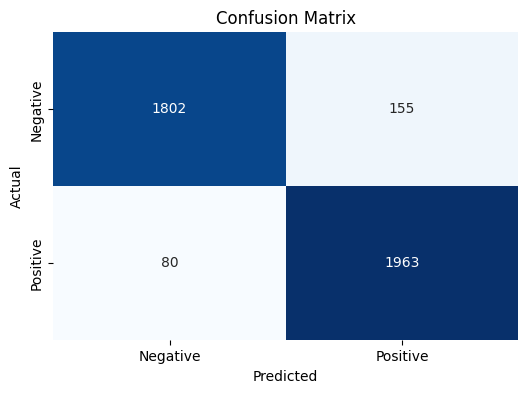

In [ ]:
predict_sentiment_and_evaluate(model, tokenizer, X_test, y_test, device)

## Load the fine-tuned model from hugging face

In [54]:
%%writefile inference.py
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

model_name = 'luluw/distilbert-base-uncased-finetuned-sentiment'
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name)

# Example usage
text = "I love this product!"
inputs = tokenizer(text, return_tensors='pt')
outputs = model(**inputs)
predictions = torch.argmax(outputs.logits, dim=-1)

print(text)
print("positive" if predictions==1 else "negative")

In [55]:
!python3 inference.py